In [58]:
import os
import sys
import json

import pydicom
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from tcia_utils import nbia
from rt_utils import RTStructBuilder
from monai.bundle import ConfigParser, download, MetaProperties
from monai.transforms import (
    LoadImage,
    LoadImaged,
    Orientation,
    Orientationd,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    Compose,
)

In [5]:
project_environment_directory = os.path.abspath(sys.prefix)
project_directory = os.path.dirname(project_environment_directory)

data_directory = os.path.join(project_directory, "data")
model_directory = os.path.join(project_directory, "model")
output_directory = os.path.join(project_directory, "output")

if not os.path.exists(data_directory):
    print("Data directory does not exist, new data directory created.")
    os.mkdir(data_directory)

    print(data_directory)

if not os.path.exists(model_directory):
    print("Model directory does not exist, new model directory created.")
    os.mkdir(model_directory)

    print(model_directory)

if not os.path.exists(output_directory):
    print("Output directory does not exist, new output directory created.")
    os.mkdir(output_directory)

    print(output_directory)

In [6]:
model_name = "wholeBody_ct_segmentation"
model_path = os.path.join(model_directory, model_name, "models", "model_lowres.pt")
inference_config_path = os.path.join(model_directory, model_name, "configs", "inference.json")

In [7]:
ct_series_directory = os.path.join(
    data_directory, "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668"
)

ct_series_directory

'd:\\projects\\ct-segmentation\\data\\1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668'

In [8]:
config = ConfigParser()
config.read_config(inference_config_path)

##### Get preprocessing pipeline

In [9]:
preprocessing_pipeline = config.get_parsed_content("preprocessing")

##### Preprocess image data

In [10]:
data = preprocessing_pipeline({"image": ct_series_directory})

In [ ]:
data

##### Get network model

In [11]:
model = config.get_parsed_content("network")

In [12]:
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

##### Inferer
Standardise the data by breaking it into 96x96x96 chunks

In [13]:
inferer = config.get_parsed_content("inferer")

In [14]:
postprocessing_pipeline = config.get_parsed_content("postprocessing")

#### Prediction 

In [15]:
#  Data dictionary
data = preprocessing_pipeline({"image": ct_series_directory})

# To disble backpropagation, if left enabled, it can crash the computer since it requires a powerful CPU
with torch.no_grad():
    #  To add batch dimension to a new "pred" key
    data["pred"] = inferer(data["image"].unsqueeze(0), network=model)

data["pred"] = data["pred"][0]
data["image"] = data["image"][0]

data = postprocessing_pipeline(data)
segmentation = torch.flip(data["pred"][0], dims=[2])
segmentation = segmentation.cpu().numpy()

2023-11-13 22:48:00,239 INFO image_writer.py:197 - writing: D:\projects\ct-segmentation\output\mask\1.3.6.1.4.1.14519.5.2.1.3320.3273\1.3.6.1.4.1.14519.5.2.1.3320.3273_trans.nii.gz


In [16]:
segmentation.shape

(512, 512, 975)

In [26]:
def plot_slices(original_slice, segmented_slice):
	plt.subplots(1, 2, figsize=(6, 8))
	plt.subplot(121)
	plt.pcolormesh(original_slice.T, cmap="Greys_r")
	plt.axis("off")

	plt.subplot(122)
	plt.pcolormesh(segmented_slice.T, cmap="nipy_spectral")
	plt.axis("off")

	plt.show()

In [18]:
image_preprocessing = Compose([
	LoadImage(image_only=True),
	EnsureChannelFirst(),
	Orientation(axcodes="LPS")
])

ct_image = image_preprocessing(ct_series_directory)

In [34]:
ct_coronal_slice = ct_image[0,:, 300].cpu().numpy()
segmented_ct_coroal_slice = segmentation[:, 300]

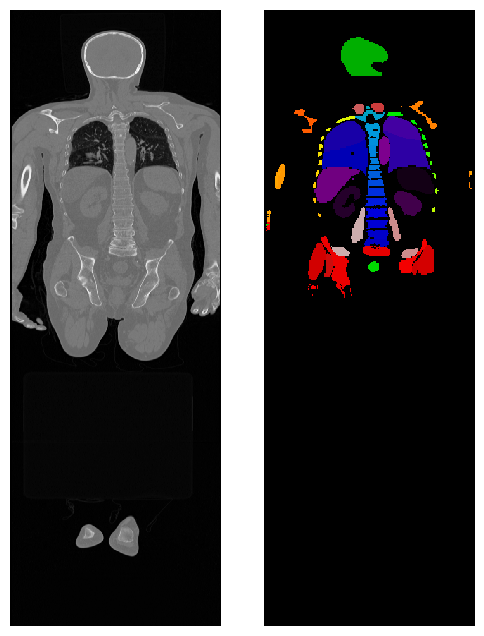

In [35]:
plot_slices(ct_coronal_slice, segmented_ct_coroal_slice)

In [48]:
ct_image.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[ -0.9766,   0.0000,   0.0000, 249.5117],
         [  0.0000,  -0.9766,   0.0000, 401.0117],
         [  0.0000,   0.0000,   2.0000, -11.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 origi

#### 1. Computing bladder volume 

In [55]:
bladder_voxel_count = (segmentation == 104).sum().item()
print(f"Bladder voxel count: {bladder_voxel_count}")

voxel_volume_in_cm3 = torch.prod(torch.from_numpy(ct_image.meta["spacing"] / 10))

bladder_volume = bladder_voxel_count * voxel_volume_in_cm3
print(f"Bladder volume is {bladder_volume:.3f} cm^3")

Bladder voxel count: 74742
Bladder volume is 142.559 cm^3


#### 2. Computing volume of any organ in channel_def metadata

In [80]:
def calculate_organ_volume(segmentation: Tensor, image, channel_def: int):
	organ_voxel_count = (segmentation == channel_def).sum().item()
	voxel_volume_in_cm3 = torch.prod(torch.from_numpy(image.meta["spacing"] / 10))

	organ_volume = organ_voxel_count * voxel_volume_in_cm3

	return f"{organ_volume:.3f} cm^3"				

In [84]:
print(f"Stomach volume: {calculate_organ_volume(segmentation,ct_image, 6)}")
print(f"Aorta volume: {calculate_organ_volume(segmentation,ct_image, 7)}")

Stomach volume: 402.836 cm^3
Aorta volume: 335.619 cm^3
